First I defined parameters that would fit a wide-gap version of Umurhan+ 2007. To this end I used the $\beta$, $Pm$, $Rm$, $Q$ from Umurhan+ 2007, the $R_1, R_2$, and $\Omega_1$ from [Goodman & Ji 2002](http://arxiv.org/pdf/astro-ph/0104206v1.pdf Goodman & Ji 2002).

And then I determined what value of $\Omega_2$, the rotation rate of the outer cylinder, would yield an approximately Keplerian shear profile at $r_0 = 10$, the center of the channel. This is achieved by plugging in values to Equation 25 of Goodman & Ji 2002 and solving for $\zeta = 2 - q = 0.5$. I get $\Omega_2 = 67$.

In [83]:
%matplotlib inline

In [84]:
# Parameters approximating Umurhan+ 2007
Pm = 1.0E-3
beta = 25.0
R1 = 5
R2 = 15
Omega1 = 314
Omega2 = 67.15933620640001
Q = 0.748
Rm = 4.879

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as de
from scipy.linalg import eig, norm
import pylab
import copy
import pickle
import random

#import logging 
#root = logging.root 
#for h in root.handlers: 
#    h.setLevel("DEBUG") 

logger = logging.getLogger(__name__)

import matplotlib
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

nr1 = 64
r1 = de.Chebyshev('r', nr1, interval=(5, 15))
d1 = de.Domain([r1])

nr2 = 128
r2 = de.Chebyshev('r', nr2, interval=(5, 15))
d2 = de.Domain([r2])

print("grid number {}, spurious eigenvalue check at {}".format(nr1, nr2))

class MRI():

    """
    Base class for MRI equations.
    
    Defaults: For Pm of 0.001 critical Rm is 4.879  critical Q is 0.748
    """

    def __init__(self, Q = np.pi/10, Rm = 4.052, Pm = 1.6E-6, beta = 0.4378, R1 = 9.5, R2 = 10.5, Omega1 = 314, Omega2 = 37.9, norm = True):
    
        self.Q = Q
        self.Rm = Rm
        self.Pm = Pm
        self.beta = beta
        self.norm = norm
        
        # Inverse magnetic reynolds number
        self.iRm = 1.0/self.Rm
        
        # Reynolds number
        self.R = self.Rm/self.Pm
        self.iR = 1.0/self.R
        
        self.gridnum1 = nr1
        self.gridnum2 = nr2
        self.r = r1.grid()
        
        self.R1 = R1
        self.R2 = R2
        self.Omega1 = Omega1
        self.Omega2 = Omega2
        
        self.R0 = (self.R1 + self.R2)/2.0 # center of channel

        self.c1 = (self.Omega2*self.R2**2 - self.Omega1*self.R1**2)/(self.R2**2 - self.R1**2)
        self.c2 = (self.R1**2*self.R2**2*(self.Omega1 - self.Omega2))/(self.R2**2 - self.R1**2)
        
        self.zeta_mean = 2*(self.R2**2*self.Omega2 - self.R1**2*self.Omega1)/((self.R2**2 - self.R1**2)*np.sqrt(self.Omega1*self.Omega2))
    
        print("MRI parameters: ", self.Q, self.Rm, self.Pm, self.beta, "R1 = ", self.R1, "R2 = ", self.R2, 'norm = ', norm, "Reynolds number", self.R)
        
        
    def set_boundary_conditions(self, problem):
        
        """
        Adds MRI problem boundary conditions to a ParsedProblem object.
        """
        
        problem.add_bc('left(u) = 0')
        problem.add_bc('right(u) = 0')
        problem.add_bc('left(psi) = 0')
        problem.add_bc('right(psi) = 0')
        problem.add_bc('left(A) = 0')
        problem.add_bc('right(A) = 0')
        #problem.add_bc('left(psi + r*psir) = 0')
        #problem.add_bc('right(psi + r*psir) = 0')
        problem.add_bc('left(psir) = 0')
        problem.add_bc('right(psir) = 0')
        problem.add_bc('left(B + r*Br) = 0')
        problem.add_bc('right(B + r*Br) = 0') # axial component of current = 0
        
        return problem
    
    def solve_LEV(self, problem):
    
        """
        Solves the linear eigenvalue problem for a ParsedProblem object.
        """
        
        problem.expand(domain)
        LEV = LinearEigenvalue(problem, domain)
        print(LEV.pencils[0].L)
        LEV.solve(LEV.pencils[0])
        
        return LEV
        
    def solve_LEV_secondgrid(self, problem):
    
        """
        Solves the linear eigenvalue problem for a ParsedProblem object.
        Uses gridnum = 192 domain. For use in discarding spurious eigenvalues.
        """
        
        problem.expand(domain192)
        LEV = LinearEigenvalue(problem, domain192)
        LEV.solve(LEV.pencils[0])
        
        return LEV
        
    def solve_BVP(self, problem):
    
        """
        Solves the boundary value problem for a ParsedProblem object.
        """
    
        problem.expand(domain, order = gridnum)
        BVP = LinearBVP(problem, domain)
        BVP.solve()
        
        return BVP
        
        
    def discard_spurious_eigenvalues(self, lambda1, lambda2):
    
        """
        lambda1 :: eigenvalues from low res run
        lambda2 :: eigenvalues from high res run
        
        Solves the linear eigenvalue problem for two different resolutions.
        Returns trustworthy eigenvalues using nearest delta, from Boyd chapter 7.
        """

        # Reverse engineer correct indices to make unsorted list from sorted
        reverse_lambda1_indx = np.arange(len(lambda1)) 
        reverse_lambda2_indx = np.arange(len(lambda2))
    
        lambda1_and_indx = np.asarray(list(zip(lambda1, reverse_lambda1_indx)))
        lambda2_and_indx = np.asarray(list(zip(lambda2, reverse_lambda2_indx)))
        
        # remove nans
        lambda1_and_indx = lambda1_and_indx[np.isfinite(lambda1)]
        lambda2_and_indx = lambda2_and_indx[np.isfinite(lambda2)]
    
        # Sort lambda1 and lambda2 by real parts
        lambda1_and_indx = lambda1_and_indx[np.argsort(lambda1_and_indx[:, 0].real)]
        lambda2_and_indx = lambda2_and_indx[np.argsort(lambda2_and_indx[:, 0].real)]
        
        lambda1_sorted = lambda1_and_indx[:, 0]
        lambda2_sorted = lambda2_and_indx[:, 0]
    
        # Compute sigmas from lower resolution run (gridnum = N1)
        sigmas = np.zeros(len(lambda1_sorted))
        sigmas[0] = np.abs(lambda1_sorted[0] - lambda1_sorted[1])
        sigmas[1:-1] = [0.5*(np.abs(lambda1_sorted[j] - lambda1_sorted[j - 1]) + np.abs(lambda1_sorted[j + 1] - lambda1_sorted[j])) for j in range(1, len(lambda1_sorted) - 1)]
        sigmas[-1] = np.abs(lambda1_sorted[-2] - lambda1_sorted[-1])

        if not (np.isfinite(sigmas)).all():
            print("WARNING: at least one eigenvalue spacings (sigmas) is non-finite (np.inf or np.nan)!")
    
        # Nearest delta
        delta_near = np.array([np.nanmin(np.abs(lambda1_sorted[j] - lambda2_sorted)/sigmas[j]) for j in range(len(lambda1_sorted))])
    
        # Discard eigenvalues with 1/delta_near < 10^6
        lambda1_and_indx = lambda1_and_indx[np.where((1.0/delta_near) > 1E6)]
        #print(lambda1_and_indx)
        
        lambda1 = lambda1_and_indx[:, 0]
        indx = lambda1_and_indx[:, 1]
        
        return lambda1, indx

    def get_largest_real_eigenvalue_index(self, LEV, goodevals = None, goodevals_indx = None):
        
        """
        Return index of largest eigenvalue. Can be positive or negative.
        """
        
        if goodevals == None:
            evals = LEV.eigenvalues
        else:
            evals = goodevals
        
        largest_eval_pseudo_indx = np.nanargmax(goodevals.real)
        largest_eval_indx = goodevals_indx[largest_eval_pseudo_indx]
        
        print("largest eigenvalue indx", largest_eval_indx)
        
        return largest_eval_indx
        
class OrderE(MRI):

    """
    Solves the order(epsilon) equation L V_1 = 0
    This is simply the linearized wide-gap MRI.
    Returns V_1
    """

    def __init__(self, Q = np.pi/10, Rm = 4.052, Pm = 1.6E-6, beta = 0.4378, R1 = 9.5, R2 = 10.5, Omega1 = 314, Omega2 = 37.9, norm = True, inviscid = False):
        
        print("initializing wide gap Order epsilon")
        
        MRI.__init__(self, Q = Q, Rm = Rm, Pm = Pm, R1 = R1, R2 = R2, beta = beta, norm = norm)
    
        # widegap order epsilon
        widegap1 = de.EVP(d1,['psi','u', 'A', 'B', 'psir', 'psirr', 'psirrr', 'ur', 'Ar', 'Br'],'sigma')
        widegap2 = de.EVP(d2,['psi','u', 'A', 'B', 'psir', 'psirr', 'psirrr', 'ur', 'Ar', 'Br'],'sigma')
        
        # Add equations
        for widegap in [widegap1, widegap2]:
            widegap.parameters['Q'] = self.Q
            widegap.parameters['iRm'] = self.iRm
            widegap.parameters['beta'] = self.beta
            widegap.parameters['c1'] = self.c1
            widegap.parameters['c2'] = self.c2
            
            if inviscid is True:
                widegap.parameters['iR'] = 0
            else:
                widegap.parameters['iR'] = self.iR
        
            # wrong def of omega:
            #widegap.add_equation("sigma*(-1*Q**2*r**3*psi + r**3*psirr - r**2*psir) - 3*1j*Q*r**(4 - q)*u - iR*r**3*Q**4*psi + (2/beta)*1j*Q**3*r**3*A + iR*2*Q**2*r**3*psirr - iR*2*Q**2*r**2*psir - (2/beta)*1j*Q*r**3*dr(Ar) + (2/beta)*1j*Q*r**2*Ar - iR*r**3*dr(psirrr) + 2*iR*r**2*psirrr - iR*3*r*psirr + iR*3*psir = 0")
            #widegap.add_equation("sigma*(r**4*u) - 1j*Q*q*r**(3 - q)*psi + 4*1j*Q*r**(3 - q)*psi + iR*r**4*Q**2*u - (2/beta)*1j*Q*r**4*B - iR*r**4*dr(ur) - iR*r**3*ur + iR*r**3*u = 0")
            #widegap.add_equation("sigma*(r**4*A) + iRm*r**4*Q**2*A - 1j*Q*r**4*psi - iRm*r**4*dr(Ar) + iRm*r**3*Ar = 0")
            #widegap.add_equation("sigma*(r**4*B) + 1j*Q*q*r**(3 - q)*A - 2*1j*Q*r**(3 - q)*A + iRm*r**4*Q**2*B - 1j*Q*r**4*u - iRm*r**4*dr(Br) - iRm*r**3*Br + iRm*r**2*B = 0")

            # Corrected definition of omega, and therefore of base velocity
            widegap.add_equation("sigma*(-1*Q**2*r**3*psi + r**3*psirr - r**2*psir) - iR*r**3*Q**4*psi + (2/beta)*1j*Q**3*r**3*A + 2*iR*Q**2*r**3*psirr - 2*iR*Q**2*r**2*psir - 3*1j*Q*c1*r**4*u - 3*1j*Q*c2*r**2*u - (2/beta)*1j*Q*r**3*dr(Ar) + (2/beta)*1j*Q*r**2*Ar - iR*r**3*dr(psirrr) + 2*iR*r**2*psirrr - 3*iR*r*psirr + 3*iR*psir = 0") # multiplied by r**4
            widegap.add_equation("sigma*(r**3*u) + iR*r**3*Q**2*u + 4*1j*Q*c1*r**2*psi + 2*1j*Q*c2*psi - (2/beta)*1j*Q*r**3*B - iR*r**3*dr(ur) - iR*r**2*ur + iR*r**2*u = 0") # multiplied by r**3
            widegap.add_equation("sigma*(r*A) + iRm*r*Q**2*A - 1j*Q*r*psi - iRm*r*dr(Ar) + iRm*Ar = 0") # multiplied by r
            widegap.add_equation("sigma*(r**2*B) + iRm*r**2*Q**2*B - 2*1j*Q*c1*r*A - 1j*Q*r**2*u - iRm*r**2*dr(Br) - iRm*r*Br + iRm*B = 0") # multiplied by r**2


            widegap.add_equation("dr(psi) - psir = 0")
            widegap.add_equation("dr(psir) - psirr = 0")
            widegap.add_equation("dr(psirr) - psirrr = 0")
            widegap.add_equation("dr(u) - ur = 0")
            widegap.add_equation("dr(A) - Ar = 0")
            widegap.add_equation("dr(B) - Br = 0")
        
            widegap = self.set_boundary_conditions(widegap)
        
        solver1 = widegap1.build_solver()
        solver2 = widegap2.build_solver()
        
        solver1.solve(solver1.pencils[0])
        solver2.solve(solver2.pencils[0])
        
        # Discard spurious eigenvalues
        ev1 = solver1.eigenvalues
        ev2 = solver2.eigenvalues
        self.goodeigs, self.goodeigs_indices = self.discard_spurious_eigenvalues(ev1, ev2)

        #goodeigs_index = np.where(self.goodeigs.real == np.nanmax(self.goodeigs.real))[0][0]
        print(self.goodeigs)
        try:
            goodeigs_index = np.nanargmax(self.goodeigs.real)
            self.marginal_mode_index = int(self.goodeigs_indices[goodeigs_index])
        
            solver1.set_state(self.marginal_mode_index)
        
            self.solver1 = solver1
        
            self.psi = self.solver1.state['psi']
            self.u = self.solver1.state['u']
            self.A = self.solver1.state['A']
            self.B = self.solver1.state['B']
        except ValueError:
            print("No good eigenvalues found!!!")
            self.solver1 = solver1

2016-04-27 19:07:57,078 domain 0/1 DEBUG :: Global coeff shape: [64]
2016-04-27 19:07:57,079 distributor 0/1 DEBUG :: Mesh: []
2016-04-27 19:07:57,082 domain 0/1 DEBUG :: Global coeff shape: [128]
2016-04-27 19:07:57,084 distributor 0/1 DEBUG :: Mesh: []
grid number 64, spurious eigenvalue check at 128


In [86]:
oe = OrderE(Q = Q, Rm = Rm, Pm = Pm, beta = beta, R1 = R1, R2 = R2, Omega1 = Omega1, Omega2 = Omega2)

initializing wide gap Order epsilon
MRI parameters:  0.748 4.879 0.001 25.0 R1 =  5 R2 =  15 norm =  True Reynolds number 4878.999999999999
2016-04-27 19:07:57,097 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2016-04-27 19:07:57,098 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2016-04-27 19:07:57,100 problems 0/1 DEBUG :: Parsing Eqn 0
2016-04-27 19:07:57,101 problems 0/1 DEBUG ::   Condition: True
2016-04-27 19:07:57,102 problems 0/1 DEBUG ::   LHS string form: sigma*(-1*Q**2*r**3*psi + r**3*psirr - r**2*psir) - iR*r**3*Q**4*psi + (2/beta)*1j*Q**3*r**3*A + 2*iR*Q**2*r**3*psirr - 2*iR*Q**2*r**2*psir - 3*1j*Q*c1*r**4*u - 3*1j*Q*c2*r**2*u - (2/beta)*1j*Q*r**3*dr(Ar) + (2/beta)*1j*Q*r**2*Ar - iR*r**3*dr(psirrr) + 2*iR*r**2*psirrr - 3*iR*r*psirr + 3*iR*psir
2016-04-27 19:07:57,103 problems 0/1 DEBUG ::   RHS string form: 0
2016-04-27 19:07:57,113 problems 0/1 DEBUG ::   LHS object form: ((((((((((((sigma*(((((-1*(Q**2))*(r**3))*psi) +

/Users/susanclark/dedalus_upgraded/dedalus/lib/python3.4/site-packages/ipykernel/__main__.py:269: ComplexWarning: Casting complex values to real discards the imaginary part


This doesn't give me crazy eigenvectors.... $\Psi$ looks a little underresolved but not to an extreme extent. $u$ looks underresolved, or wrong, but $A$ and $B$ look perfectly reasonable.

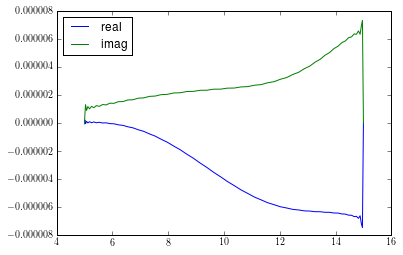

In [100]:
plt.plot(oe.r, oe.psi['g'])
plt.plot(oe.r, oe.psi['g'].imag)
plt.legend(['real', 'imag'], loc = 2)

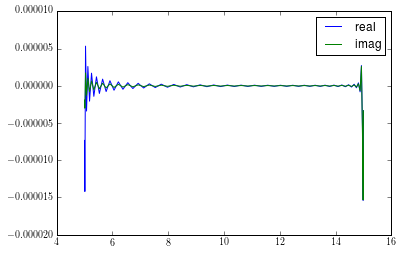

In [101]:
plt.plot(oe.r, oe.u['g'])
plt.plot(oe.r, oe.u['g'].imag)
plt.legend(['real', 'imag'])

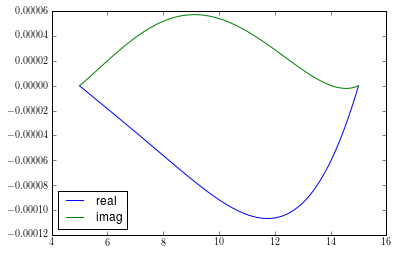

In [102]:
plt.plot(oe.r, oe.A['g'])
plt.plot(oe.r, oe.A['g'].imag)
plt.legend(['real', 'imag'], loc = 3)

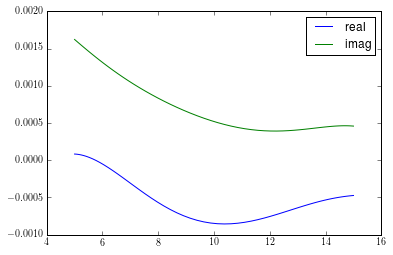

In [103]:
plt.plot(oe.r, oe.B['g'])
plt.plot(oe.r, oe.B['g'].imag)
plt.legend(['real', 'imag'])

But as we can see below, the good (non-spurious) eigenvalues don't include a growing mode, and only two of them are ~purely real. I've done a parameter-space sweep and the only eigenvalues I can find that are critical are the trivial solution, i.e. $k_z = 0$. WHY?!!

In [97]:
oe.goodeigs

array([ -6.55281884e+03 -1.54820610e-13j,
        -6.20201187e-01 +3.24035416e-03j,
        -4.37668565e-01 +4.11463390e-03j,
        -4.37668565e-01 -4.11463389e-03j,
        -2.94944487e-01 -5.29196849e-03j,
        -2.94944487e-01 +5.29196849e-03j,
        -1.83688955e-01 +5.55728654e-12j,
        -1.30979011e-01 -3.77081352e-02j,  -1.30979010e-01 +3.77081352e-02j])

In [104]:
#oe.solver1.set_state(oe.goodeigs_indices[np.where(np.abs(oe.goodeigs) == np.nanmin(np.abs(oe.goodeigs[oe.goodeigs > 0])))][0])

In [ ]:
plt.plot(oe.r, oe.B['g'])
plt.plot(oe.r, oe.B['g'].imag)

Although these eigenvalues are clearly not critical:

In [ ]:
oe.goodeigs_indices

In [ ]:
for good_indx in range(len(oe.solver1.eigenvalues)):#oe.goodeigs_indices:
    oe.solver1.set_state(int(good_indx))
    plt.plot(oe.r, oe.solver1.state['psi']['g'])

oe.zeta_mean

In [ ]:
oe.zeta_mean

In [ ]:
oe.Pm, oe.R1, oe.R2

In [ ]:
mri = MRI(Q = Q, Rm = Rm, Pm = Pm, beta = beta, R1 = R1, R2 = R2, Omega1 = Omega1, Omega2 = Omega2)

AttributeError: 'function' object has no attribute 'dtype'